# guided backpropagation

In [1]:
pip install torch torchvision matplotlib captum

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: sympy in d:\users\admin\anaconda3\lib\site-packages (from torch) (1.8)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.5.0
    Uninstalling typing-extensions-4.5.0:
      Successfully uninstalled typing-extensions-4.5.0



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.
pdpbox 0.3.0 requires matplotlib>=3.6.2, but you have matplotlib 3.4.3 which is incompatible.


In [5]:
pip install tensorflow matplotlib tensorflow-addons

  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.12.2
    Uninstalling typing-extensions-4.12.2:
      Successfully uninstalled typing-extensions-4.12.2
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.4.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.
pdpbox 0.3.0 requires matplotlib>=3.6.2, but you have matplotlib 3.4.3 which is incompatible.


In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import numpy as np

In [3]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|████████████████████████████████████████████████████████████████| 170498071/170498071 [05:44<00:00, 495298.62it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to C:\Users\admin/.cache\torch\hub\v0.6.0.zip
D:\Users\admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Users\admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\admin/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [01:28<00:00, 528kB/s]

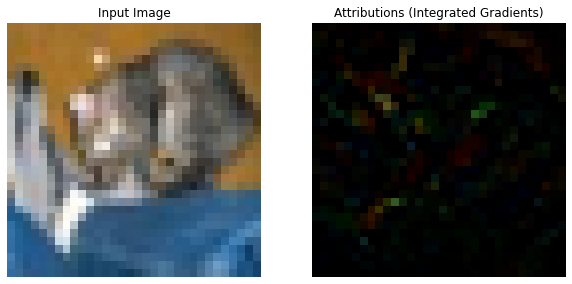

In [4]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
cifar10_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
image, label = cifar10_data[0]  # Select the first image and its label

# Load or create a model e.g., a simple CNN 
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
model.eval()
model = model.to(device)

# Move image to the correct device and normalize
image = image.unsqueeze(0).to(device)  # Add batch dimension
image.requires_grad_()

# Compute relevance using Integrated Gradients
ig = IntegratedGradients(model)
attributions = ig.attribute(image, target=label)

# Convert the attribution to NumPy array for visualization
attributions = attributions.squeeze().detach().cpu().numpy()
image_np = image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_np)
ax[0].set_title('Input Image')
ax[0].axis('off')

ax[1].imshow(attributions.transpose(1, 2, 0), cmap='hot')
ax[1].set_title('Attributions (Integrated Gradients)')
ax[1].axis('off')

plt.show()

58889256/58889256 [==============================] - 113s 2us/step


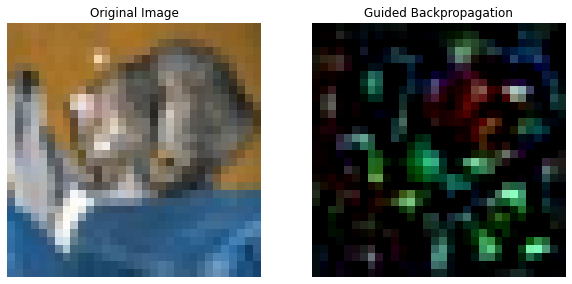

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_test = x_test.astype('float32') / 255.0  # Normalize the images

# Load a pre-trained model
base_model = keras.applications.VGG16(weights='imagenet', include_top=False)

# Define a guided backpropagation model
class GuidedBackpropModel(keras.Model):
    def __init__(self, model):
        super(GuidedBackpropModel, self).__init__()
        self.model = model

    @tf.function
    def call(self, inputs):
        return self.model(inputs)

    def get_gradients(self, inputs, target_class_index):
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            predicted_output = self.model(inputs)
            loss = predicted_output[:, target_class_index]
        gradients = tape.gradient(loss, inputs)
        return gradients

guided_model = GuidedBackpropModel(base_model)
guided_model.trainable = False

# Pick a random image from the test data
idx = 0  # Select the first image
test_image = np.expand_dims(x_test[idx], axis=0)
true_label = np.argmax(y_test[idx])

# Compute gradients
gradients = guided_model.get_gradients(tf.convert_to_tensor(test_image), true_label)
guided_backprop = tf.maximum(gradients, 0)

# Plot the original image and the guided backpropagation result
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(test_image[0])
plt.title('Original Image')
plt.axis('off')

# Guided Backpropagation Result
plt.subplot(1, 2, 2)
plt.imshow(guided_backprop[0] / np.max(guided_backprop[0]), cmap='hot')
plt.title('Guided Backpropagation')
plt.axis('off')

plt.show()